# xSiGra model explanations detailed

## Here we show how to compute explanation for 1 fov

## Import modules

In [1]:
import sys
sys.path.append('../xSiGra_model')
from utils import Cal_Spatial_Net
import warnings
warnings.filterwarnings('ignore')

In [3]:
import argparse
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy.optimize import linear_sum_assignment
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torchvision import models, transforms
from train_transformer import get_explanations, train_nano_fov, test_nano_fov
from transModel import ClusteringLayer
from utils import Cal_Spatial_Net, Stats_Spatial_Net, _hungarian_match

os.environ["PYTHONHASHSEED"] = "1234"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"



## Set hyperparamaters

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--root', type=str, default='../dataset/nanostring/lung13')
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--id', type=str, default='fov1')
parser.add_argument('--img_name', type=str, default='F001')
parser.add_argument('--neurons', type=str, default='512,30')
parser.add_argument('--num_layers', type=str, default="2")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--save_path', type=str, default='../checkpoint_fov1/nanostring_train_lung13_tutorial')
parser.add_argument('--ncluster', type=int, default=8)
parser.add_argument('--repeat', type=int, default=1)
parser.add_argument('--use_gray', type=float, default=0)
parser.add_argument('--test_only', type=int, default=1)
parser.add_argument('--pretrain', type=str, default='best.pth')
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--img_size', type=str, default='60,60')
parser.add_argument('--cluster_method', type=str, default='leiden')
parser.add_argument('--num_fov', type=int, default=1)
parser.add_argument('--dataset', type=str, default='lung13')
parser.add_argument('--benchmark', type=str, default='gradcam')

opt = parser.parse_args(args=[])

root = opt.root
seed = opt.seed
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Generate adata

../dataset/nanostring/lung13/fov1/CellComposite_F001.jpg
------Calculating spatial graph...
The graph contains 12930 edges, 3332 cells.
3.8806 neighbors per cell on average.


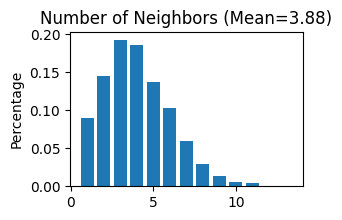

In [5]:
def gen_adatas(root, id, img_name):

    adata = sc.read(os.path.join(root, id, 'sampledata.h5ad'))
    adata.var_names_make_unique()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    print(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
    img = cv2.imread(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if opt.use_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    transform = transforms.ToTensor()
    img = transform(img)

    patchs = []

    w, h = opt.img_size.split(",")
    w = int(w)
    h = int(h)

    for coor in adata.obsm['spatial']:
        x, y = coor
        img_p = img[:, int(y-h):int(y+h), int(x-w): int(x+w)]
        patchs.append(img_p.flatten()) # 4 * h * w
    patchs = np.stack(patchs)

    df = pd.DataFrame(patchs, index=adata.obs.index)
    adata.obsm['imgs'] = df

    Cal_Spatial_Net(adata, rad_cutoff=80)
    Stats_Spatial_Net(adata)
    return adata

ids = ['fov'+str(i) for i in range(1,int(opt.num_fov)+1)]
img_names = ['F00'+str(i) for i in range(1,10)]
img_names = img_names + ['F0'+str(i) for i in range(10,int(opt.num_fov)+1)]

adatas = list()
for id, name in zip(ids, img_names):
    adata = gen_adatas(opt.root, id, name)
    adatas.append(adata)

sp = os.path.join(opt.save_path, 'all')

## Train model for fov1 or use your saved checkpoints for fov1 and directly test

In [6]:
train_nano_fov(
    opt,
    adatas,
    hidden_dims=opt.neurons,
    n_epochs=opt.epochs,
    lr=opt.lr,
    random_seed=opt.seed,
    save_path=sp,
    repeat=0,
)

100%|██| 200/200 [00:43<00:00,  4.55it/s]


AnnData object with n_obs × n_vars = 3332 × 980
    obs: 'cell_type', 'cx', 'cy', 'cx_g', 'cy_g', 'merge_cell_type'
    uns: 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'spatial_global', 'imgs'

## Choose best model for fov1 or use your saved anndata for fov1

In [7]:
adata_pred = test_nano_fov(
    opt,
    adatas,
    hidden_dims=opt.neurons,
    random_seed=opt.seed,
    save_path=sp,
)

../checkpoint_fov1/nanostring_train_lung13_tutorial/all/final_191_0.pth


2023-10-14 21:21:31.648386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 21:21:34.990836: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1.5
0.75
0.375
0.5625
0.46875
0.421875
0.3984375
0.38671875
0.392578125
find 0.392578125
Davies_bouldin: 1.78
ARI: 0.45
ARI: 0.45
../checkpoint_fov1/nanostring_train_lung13_tutorial/all/final_192_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 1.79
ARI: 0.53
../checkpoint_fov1/nanostring_train_lung13_tutorial/all/final_193_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
0.3984375
0.41015625
find 0.41015625
Davies_bouldin: 1.93
ARI: 0.41
../checkpoint_fov1/nanostring_train_lung13_tutorial/all/final_194_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
find 0.421875
Davies_bouldin: 1.75
ARI: 0.46
ARI: 0.46
../checkpoint_fov1/nanostring_train_lung13_tutorial/all/final_195_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
0.3984375
0.38671875
find 0.38671875
Davies_bouldin: 1.86
ARI: 0.53
../checkpoint_fov1/nanostring_train_lung13_tutorial/all/final_196_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
0.3984375
find 0.3984375
Davies_bouldin: 1.79
ARI: 0.52
../checkpoint_fov1/nanostring_train_lung13_tutoria

## Compute ARI

In [8]:
sc.pp.neighbors(adata_pred, opt.ncluster, use_rep="pred")

In [9]:

def res_search(adata_pred, ncluster, seed, iter=200):
    start = 0
    end = 3
    i = 0
    while start < end:
        if i >= iter:
            return res
        i += 1
        res = (start + end) / 2

        random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        sc.tl.leiden(adata_pred, random_state=seed, resolution=res)
        count = len(set(adata_pred.obs["leiden"]))
        if count == ncluster:
            return res
        if count > ncluster:
            end = res
        else:
            start = res
    raise NotImplementedError()

# Perform leiden clustering
res = res_search(adata_pred, opt.ncluster, opt.seed)
sc.tl.leiden(adata_pred, resolution=res, key_added="leiden", random_state=opt.seed)
obs_df = adata_pred.obs.dropna()

ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
print('ARI: %.2f'%ARI)

ARI: 0.57


## Train linear layer to convert leiden clusters to probability using celltype as ground truth

In [10]:
class Custom_Dataset(Dataset):
    def __init__(self, indata, label):
        self.indata = indata
        self.label = [int(item) for item in label.values.tolist()]
        self.label = np.array(self.label)
    
    def __len__(self):
        return len(self.indata)

    def __getitem__(self, index):
        indata = torch.tensor(self.indata[index])
        label = torch.tensor(self.label[index])
        return indata, label

cross_el = torch.nn.CrossEntropyLoss()
obs_df = adata_pred.obs.dropna()

device = torch.device(opt.device if torch.cuda.is_available() else "cpu")
linmodel = ClusteringLayer(opt.ncluster).to(device)

labels = obs_df["merge_cell_type"].tolist()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
gt = le.fit_transform(labels)
print(le.classes_)
y = pd.DataFrame(gt, columns =['merge_cell_type'])

dataset = Custom_Dataset(adata_pred.obsm['pred'], y['merge_cell_type'])
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

optimizer = torch.optim.Adam(linmodel.parameters(), lr=0.001)
epochs = 30

train_loss = []
train_acc = []
total_step = len(train_loader)

for epoch in range(epochs): 
    linmodel.train()
    correct = 0
    running_loss = 0.0
    total = 0

    for idx, batch in enumerate(train_loader):
        data, labels = batch
        optimizer.zero_grad()
        out = linmodel(data.float().to(device))
        loss = cross_el(out, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        x = torch.nn.functional.log_softmax(out,dim = 1)
        _,pred = torch.max(x, dim=1)
        correct += torch.sum(pred==labels.to(device)).item()
        total += labels.size(0)
        if (idx) % 20 == 0:
            print(loss.item()) 
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')

if not os.path.exists(os.path.join("../saved_model_fov1/" + opt.dataset)):
    os.makedirs(os.path.join("../saved_model_fov1/" + opt.dataset))    
torch.save(linmodel.state_dict(), '../saved_model_fov1/'+opt.dataset+'/linmodel_gt.pth')

['endothelial' 'epithelial' 'fibroblast' 'lymphocyte' 'mast' 'myeloid'
 'neutrophil' 'tumors']
2.062751054763794
0.6849991083145142

train loss: 0.9720, train acc: 73.7711
0.5046316981315613
0.44000017642974854

train loss: 0.7414, train acc: 82.9644
0.4778059720993042
0.26733288168907166

train loss: 0.6270, train acc: 86.0413
0.36947762966156006
0.26081836223602295

train loss: 0.5588, train acc: 86.8293
0.2874548137187958
0.3590066432952881

train loss: 0.5109, train acc: 87.6548
0.2807098925113678
0.37260568141937256

train loss: 0.4756, train acc: 88.6679
0.28875651955604553
0.23319965600967407

train loss: 0.4474, train acc: 89.9812
0.36375588178634644
0.20894473791122437

train loss: 0.4256, train acc: 89.9062
0.27625173330307007
0.2906970977783203

train loss: 0.4073, train acc: 90.0188
0.1800493746995926
0.28835874795913696

train loss: 0.3916, train acc: 90.7317
0.21729464828968048
0.2582908868789673

train loss: 0.3782, train acc: 90.9944
0.18634077906608582
0.26536753773689

## Test

## Match clusters to cells

In [11]:
correct = 0
running_loss = 0.0
total = 0
total_step = len(test_loader)

linmodel = ClusteringLayer(opt.ncluster).to(device)
linmodel.load_state_dict(torch.load('../saved_model_fov1/'+opt.dataset+'/linmodel_gt.pth'))
linmodel = linmodel.to(device)
linmodel.eval()

for idx, batch in enumerate(test_loader):
    data, labels = batch
    out = linmodel(data.float().to(device))
    x = torch.nn.functional.log_softmax(out,dim = 1)
    _,pred = torch.max(x, dim=1)
    correct += torch.sum(pred==labels.to(device)).item()
    total += labels.size(0)
    
test_acc = 100 * correct / total
print(f'\ntest acc: {(100 * correct / total):.4f}')


test acc: 87.7061


## Load VGG model

In [12]:
model = models.vgg16(pretrained=True)


# Pretrained VGG-16
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        self.pooling = model.avgpool
        self.flatten = nn.Flatten()
        self.fc = model.classifier[0]

    def forward(self, x):
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


model = models.vgg16(pretrained=True)
vgg_model = FeatureExtractor(model)

## Compute explanations

### Cluster explanations with cell and gene importance scores to identify the particular cluster are stored in ../cluster_results_gradcam_fov1_gt1

In [13]:
import time
start_time = time.time()

## Set seed

In [14]:
seed = 1234
start_time = time.time()

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
import os
import random
import sys
import time

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import sklearn
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from sklearn import preprocessing
from sklearn.metrics.cluster import adjusted_rand_score
from torch import nn
from torch_geometric.loader import DataLoader
from torchvision import models, transforms
from tqdm import tqdm

sys.path.append("../")
from transModel import xSiGraModel, TransImg
from utils import Transfer_img_Data


## Process adata

In [16]:
opt.pretrain = "best.pth"
save_path=opt.save_path + "/all/"
datas = []
gene_dim = 0
img_dim = 0

w, h = opt.img_size.split(",")
w = int(w)
h = int(h)

device = torch.device(opt.device if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
vgg_model = FeatureExtractor(model)
vgg_model = vgg_model.to(device)

for adata in adatas:
    import scipy.sparse as sp
    adata.X = sp.csr_matrix(adata.X)
    data, img = Transfer_img_Data(adata)
    gene_dim = data.x.shape[1]
    img_dim = img.x.shape[1]

    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    )

    features = []
    img_transformed = img.x.numpy()

    for i in range(img_transformed.shape[0]):
        img = img_transformed[i].reshape(w * 2, h * 2, 3)
        img = transform(np.uint8(img))
        img = img.reshape(1, 3, 224, 224)
        img = img.to(device)

        with torch.no_grad():
            feature = vgg_model(img)

        img = feature
        features.append(img.cpu().detach().numpy().reshape(-1))

    features = np.array(features)
    features = np.vstack(features).astype(np.float)
    img = torch.from_numpy(features)

    img_dim = features.shape[1]

    hidden_dims = opt.neurons
    hidden_dims_arr = hidden_dims.split(",")
    arr = []
    for i in hidden_dims_arr:
        arr.append(int(i))
    hidden_dims = arr

    data.x = torch.cat([data.x, img], dim=1)
    datas.append(data)

adata = anndata.concat(adatas)
loader = DataLoader(datas, batch_size=1, num_workers=0, shuffle=False)

## Create model instance

In [17]:
model = TransImg(hidden_dims=[gene_dim, img_dim] + hidden_dims).to(device)


model.load_state_dict(
    torch.load(os.path.join(save_path, opt.pretrain), map_location=device)
)

model.eval()

clustermodel = xSiGraModel(
    hidden_dims=[gene_dim, img_dim] + hidden_dims,
    pretrained_model=model,
    num_clusters=opt.ncluster,
).to(device)

## Load classification layer weights

In [18]:
clustermodel.out1.weight.data = linmodel.out1.weight.data.to(device)
clustermodel.out2.weight.data = linmodel.out2.weight.data.to(device)
clustermodel.out1.bias.data = linmodel.out1.bias.data.to(device)
clustermodel.out2.bias.data = linmodel.out2.bias.data.to(device)


## Freeze model

In [19]:
for name, param in clustermodel.named_parameters():
        param.requires_grad = False

clustermodel.out1.weight.requires_grad = False
clustermodel.out1.bias.requires_grad = False
clustermodel.out2.weight.requires_grad = False
clustermodel.out2.bias.requires_grad = False

## Functions to compute cell-level and gene-level explanations

In [20]:
def compute_explanations(device, model, cluster, out, bgene, edge_index):
    model.eval()
    vsize = out.size()
    device = device
    v = torch.rand(vsize).to(device)
    grd = torch.zeros(vsize).to(device)
    out.to(device)

    # For each cluster backtrack to get gradients wrt gene expression input
    grd[:, cluster] = 1
    out.backward(gradient=grd, retain_graph=True)

    final_conv_grads = model.pretrained_model.get_activations_gradient()
    final_conv_acts = model.pretrained_model.get_activations(bgene, edge_index).detach()
    bgene.grad.zero_()
    grad_cam_weights, gene_cam_weights = grad_cam(final_conv_acts, final_conv_grads)
    return grad_cam_weights, gene_cam_weights


def grad_cam(final_conv_acts, final_conv_grads):
    node_heat_map = []
    gene_heat_map = []
    alphas = torch.mean(final_conv_grads, axis=0)
    gene_heat_map = F.relu(final_conv_grads * final_conv_acts)

    node_heat_map = F.relu(
        (final_conv_grads * final_conv_acts).sum(dim=1, keepdims=True)
    )
    return node_heat_map, gene_heat_map



## Get cluster predictions and Compute explanations for each cluster

In [21]:
cluster_weights = {}
cluster_weights_gene = {}

for i in range(0, opt.ncluster):
    cluster_weights[i] = None

for i in range(0, opt.ncluster):
    cluster_weights_gene[i] = None

# Stores the cluster label for each cell
outlabel = []
start_time = time.time()
for i, batch in enumerate(loader):
    batch = batch.to(device)
    bgene = batch.x[:, :gene_dim]
    bimg = batch.x[:, gene_dim:]
    edge_index = batch.edge_index

    bgene = bgene.float()
    bgene.requires_grad = True
    bimg = bimg.float()
    clusterlabel = clustermodel(
        bgene.float(), bimg.float(), edge_index, batch.batch
    )

    for label in clusterlabel:
        _, pred = torch.max(label, dim=0)
        outlabel.append(pred.item())

    # For each cluster get node and gene importance scores
    for k in range(0, opt.ncluster):
        node_explain, gene_explain = compute_explanations(
            device, clustermodel, k, clusterlabel, bgene.float(), edge_index
        )
        if cluster_weights[k] is None:
            cluster_weights[k] = node_explain
        else:
            cluster_weights[k] = torch.cat((cluster_weights[k], node_explain))

        if cluster_weights_gene[k] is None:
            cluster_weights_gene[k] = gene_explain
        else:
            cluster_weights_gene[k] = torch.cat(
                (cluster_weights_gene[k], gene_explain)
            )

## Store explanations in csv files for each cluster

### To use for other  specific fovs say 14 or group of fovs like 5-10 you need to modify the indices start and end to pick the correct metadata from the anndata file and fov

In [22]:
labels = adata.obs["merge_cell_type"]

def _hungarian_match(flat_preds, flat_target, preds_k, target_k):
    num_samples = flat_target.shape[0]
    num_k = preds_k
    num_correct = np.zeros((num_k, num_k))
    for c1 in range(num_k):
        for c2 in range(num_k):
            votes = int(((flat_preds == c1) * (flat_target == c2)).sum())
            num_correct[c1, c2] = votes
    match = linear_sum_assignment(num_samples - num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
    return res

le = preprocessing.LabelEncoder()
gt = le.fit_transform(labels)

leiden = np.array(outlabel)
match = _hungarian_match(
    leiden.astype(np.int8), gt.astype(np.int8), opt.ncluster, 8
)

# Maps cluster number to cell type using humgarian matching
dict_cluster_map_cell = {}
for mapping in match:
    dict_cluster_map_cell[mapping[0]] = le.classes_[mapping[1]]

for i in range(0, opt.ncluster):
    adata.obs["cmap" + str(i)] = np.array(cluster_weights[i].cpu())
for i in range(0, opt.ncluster):
    adata.uns["gmap" + str(i)] = np.array(cluster_weights_gene[i].cpu())
keys_list = ["cmap" + str(i) for i in range(opt.ncluster)]
genedf = sc.get.obs_df(adata, keys=keys_list)

# Used to fetch proper metadata from anndata file
count = 0
start = 0

ids = ["fov" + str(i) for i in range(1, int(opt.num_fov) + 1)]
img_names = ["F00" + str(i) for i in range(1, 10)]
img_names = img_names + ["F0" + str(i) for i in range(10, int(opt.num_fov) + 1)]

datas = []
adata_pred = adata

all_cells_df = pd.DataFrame()
fov = 0
fovs = []
dict_cmap = {}
gt = []
for i in range(0, opt.ncluster):
    dict_cmap["cmap" + str(i)] = []

# For each FOV
for id in ids:
    fov += 1

    adata = sc.read(
        os.path.join("../dataset/nanostring/" + opt.dataset + "/", id, "sampledata.h5ad")
    )
    
    # Update to select metadata from next fov
    start = count
    end = start + adata.shape[0]
    count = count + adata.shape[0]

    adata.var_names_make_unique()
    
    # Store gt for all fovs
    gt = gt + adata.obs["merge_cell_type"].tolist()
    for i in range(opt.ncluster):
        adata.uns["gmap" + str(i)] = adata_pred.uns["gmap" + str(i)]
        
        # Select for particular fov
        adata.obs["cmap" + str(i)] = genedf.iloc[start:end]["cmap" + str(i)]
        dict_cmap["cmap" + str(i)] = (
            dict_cmap["cmap" + str(i)] + adata.obs["cmap" + str(i)].tolist()
        )
        
    # Used to retrieve cell ids and fov_ids for metadata for all fovs
    all_cells_df1 = adata.to_df()
    all_cells_df = pd.concat([all_cells_df, all_cells_df1])
    fovs = fovs + [fov for i in range(len(all_cells_df1))]

gene_names = list(all_cells_df.columns)
adata = adata_pred

# For each cluster create csv file
## Fov
## CellID
## CellType
## Cell importance score
## Gene importance score

for k in range(0, opt.ncluster):
    cell_id = all_cells_df.reset_index()["cell_ID"]
    gmap = adata.uns["gmap" + str(k)]
    gmap_df = pd.DataFrame(gmap, columns=gene_names)
    genes_df = pd.concat([cell_id, gmap_df], axis=1)

    # Sort with highest variance
    top_genes = genes_df.var().sort_values(ascending=False)
    top_genes_df = top_genes.to_frame().reset_index()
    top_genes_df = top_genes_df.rename(columns={"index": "genes"})
    genes = top_genes_df["genes"].tolist()

    cluster_metadata_df = pd.DataFrame()
    cluster_metadata_df["fov"] = fovs
    cluster_metadata_df["cellID"] = cell_id
    cluster_metadata_df["cell_type"] = gt
    cluster_metadata_df["cell_imp_score"] = dict_cmap["cmap" + str(k)]

    cluster_metadata_df["cluster"] = outlabel
    cluster_metadata_df["cx"] = adata.obs["cx"].tolist()
    cluster_metadata_df["cy"] = adata.obs["cy"].tolist()
    cluster_metadata_df["cx_g"] = adata.obs["cx_g"].tolist()
    cluster_metadata_df["cy_g"] = adata.obs["cy_g"].tolist()

    for gene in genes:
        cluster_metadata_df[gene + " imp score"] = genes_df[gene]

    if not os.path.exists(
        os.path.join("../cluster_results_gradcam_fov1_gt1/" + opt.dataset)
    ):
        os.makedirs(os.path.join("../cluster_results_gradcam_fov1_gt1/" + opt.dataset))
    cluster_metadata_df.to_csv(
        "../cluster_results_gradcam_fov1_gt1/"
        + opt.dataset
        + "/cluster"
        + str(k)
        + "_"
        + dict_cluster_map_cell[k]
        + ".csv"
    )

end_time = time.time()
delta = end_time - start_time
sec = delta
hours = sec / (60 * 60)
print("Downstream task time in hours:", hours)

Downstream task time in hours: 0.02216945250829061


In [23]:
end_time = time.time()
delta = end_time - start_time
sec = delta
hours = sec / (60 * 60)

In [24]:
print('difference in hours:', hours)

difference in hours: 0.022173118657535976
